In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from IPython.core.display import HTML
import shutil


#dropout_rate = 0.5
#fc_dropout_rate = 0.5

dropout_rate = 0.75
fc_dropout_rate = 0.0

#dropout_rate = 0.6
#fc_dropout_rate = 0.4


# results_010_gn_lang_classification__spectrogram_dropout_0.6__fc_dropout_0.5
DATA_DIR = f'results_010_gn_lang_classification__spectrogram_dropout_{dropout_rate}__fc_dropout_{fc_dropout_rate}'

model_names = ['LangIdCNN_Mean2_FCD_Spectrogram']


# DATA_DIR = 'results_008_gn_lang_classification__dropout_0.6__fc_dropout_0.5_contrastive'
# model_names = ["LangIdCNN_Mean2_FCD_Contrastive", "LangIdCNN_Mean2_FCD"]



random.seed(42)
# COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
COLORS = ["#7f7f7f", "#1f77b4"]

BSLN_COLOR = '#7f7f7f'
OUR_COLOR = '#1f77b4'


n = 84
n_train = int(np.ceil(n * .6))
n_test = n - n_train


In [2]:
data_frames = {}

variable_names = []

for model_path in Path(DATA_DIR).iterdir():
    if not model_path.is_dir():
        continue
        
    if "NN" not in str(model_path):
        continue
    
    model_name = model_path.stem
    print(f"MODEL: {model_name}")
    fold_names = []
    
    data_frames[model_name] = {}
    
    for p in Path(model_path).iterdir():
        if not p.suffixes or p.suffixes[-1] != '.csv':
            continue
        fold_name = p.stem
        fold_names.append(fold_name)
        data_frames[model_name][fold_name] = pd.read_csv(p)
        variable_names.extend(list(data_frames[model_path.stem][p.stem].columns))
    for fold_name in sorted(fold_names):
        print(f"\t{fold_name}")

print(f"VARIABLES")        
for variable_name in sorted(set(variable_names)):
    print(f"\t{variable_name}")
        
    

MODEL: LangIdCNN_Mean2_FCD_Spectrogram
	spectrogram_0
	spectrogram_1
	spectrogram_2
	spectrogram_3
	spectrogram_4
	spectrogram_5
	spectrogram_6
	spectrogram_7
	spectrogram_8
	spectrogram_9
VARIABLES
	epoch
	test_acc
	test_acc_channel_music
	test_acc_channel_noise
	test_acc_channel_telephone
	test_acc_gender_female
	test_acc_gender_male
	test_acc_language_maninka
	test_acc_language_pular
	test_acc_language_susu
	test_acc_speaker_count_multiple
	test_acc_speaker_count_single
	test_acc_utterance_multilingual
	test_acc_utterance_verbal_nod
	test_loss
	test_n
	test_n_channel_music
	test_n_channel_noise
	test_n_channel_telephone
	test_n_gender_female
	test_n_gender_male
	test_n_language_maninka
	test_n_language_pular
	test_n_language_susu
	test_n_speaker_count_multiple
	test_n_speaker_count_single
	test_n_utterance_multilingual
	test_n_utterance_verbal_nod
	train_acc
	train_acc_channel_music
	train_acc_channel_noise
	train_acc_channel_telephone
	train_acc_gender_female
	train_acc_gender_male

In [3]:
def get_variable_stats(model_name, feature_prefix, variable, sample_size):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
    
    m = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    
    
    
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    if variable == 'test_acc':
        print(f"{model_name}, {feature_prefix} {variable}, max-mean: {np.max(m)}, max-max: {np.max(maximum)}")
        # print(f"{model_name}, {feature_prefix} {variable}, max: {np.max(m_max)}, min {np.min(m_min)}")
        max_per_fold = np.max(data, axis=(0))
        print(np.mean(max_per_fold))
        
    return data, m, sem, minimum, maximum
    
        

In [4]:
def get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    for index, df in enumerate(selected_dfs):
        best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    ep_best = np.argmax(best_epoch_selection_data, axis=0)
    
    return ep_best

def get_variable_stats(model_name, feature_prefix, variable, sample_size, best_epoch_selection_variable='test_acc'):
    selected_dfs = [v for k, v in data_frames[model_name].items() if k.startswith(feature_prefix)]
    
    epoch_count = selected_dfs[0].shape[0]
    experiment_count = len(selected_dfs)
    
    data = np.zeros((epoch_count, experiment_count))
    #best_epoch_selection_data = np.zeros((epoch_count, experiment_count))
    
    for index, df in enumerate(selected_dfs):
        data[:, index] = df[variable]
        #best_epoch_selection_data[:, index] = df[best_epoch_selection_variable]
    
    #
    # Stats of the variable @best epoch for each fold
    #
    #ep_best = np.argmax(best_epoch_selection_data, axis=0)
    ep_best = get_best_epochs_per_fold(model_name, feature_prefix, best_epoch_selection_variable)
    
    # value of the variable for the best epoch of each fold
    ep_best_values = [data[ep_best[fold_ix], fold_ix] for fold_ix in range(len(ep_best))]
    ep_best_mean = np.mean(ep_best_values)
    ep_best_sem = np.std(ep_best_values) / np.sqrt(sample_size)
    ep_best_min = np.min(ep_best_values)
    ep_best_max = np.max(ep_best_values)
    
    
    #
    # Stats of the variable @each epoch
    #
    mean = np.mean(data, axis=1)
    minimum = np.min(data, axis=1)
    maximum = np.max(data, axis=1)
    sem = np.std(data, axis=1) / np.sqrt(sample_size)
    
    stats = {
        'data': data,
        'epochs_mean': mean,
        'epochs_sem': sem,
        'epochs_min': minimum,
        'epochs_max': maximum,
        
        'best_epoch_mean': ep_best_mean,
        'best_epoch_sem': ep_best_sem,
        'best_epoch_min': ep_best_min,
        'best_epoch_max': ep_best_max
    }
    
    #if variable == 'test_acc':
    #    print(f"{model_name}, {feature_prefix} {variable}")
    #    [print(f"max {k}", np.max(v)) for k,v in stats.items() if k != 'data']
        
    return stats

In [5]:
def plot_comparative_variables(ax, model_name, feature_prefixes, variable, sample_size):
    line_styles = ['-', '-']
    for index, feature_prefix in enumerate(feature_prefixes):
        stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
        
        x = range(1, stats['data'].shape[0]+1)

        ax.plot(x, stats['epochs_mean'], color=COLORS[index], linestyle=line_styles[index], label=f'{model_name} {feature_prefix}', alpha=1)
        
        ax.fill_between(
            x, 
            stats['epochs_mean'] + stats['epochs_sem'], 
            stats['epochs_mean'] - stats['epochs_sem'], 
            color=COLORS[index], alpha=0.6
        )
        
        ax.fill_between(
            x, 
            stats['epochs_min'], 
            stats['epochs_max'], 
            color=COLORS[index], alpha=0.1
        )

    ax.grid(True)
    ax.title.set_text(variable)
    ax.legend()

In [6]:
def plot_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}

    plot_width = len(model_names)*10
    plot_height = len(variables)*10
    fig, axes = plt.subplots(len(variables), len(model_names), sharex=True, sharey='row', figsize=(plot_width, plot_height))
    axes = axes.reshape(len(variables), len(model_names))
    for variable_index, variable in enumerate(variables):
        # fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True, figsize=(20, 7))
        sample_size = sample_sizes_by_variable[variable]
        for model_index, model_name in enumerate(model_names):
            plot_comparative_variables(
                axes[variable_index, model_index], # axes[variable_index]
                model_name,
                compared_features,
                variable,
                sample_size
            )

In [7]:
# def plot_best_results(model_names, variables_and_sample_sizes, model_selection_variable, compared_features):
    

In [8]:
fold_count = 10


# test_acc
# test_acc_channel_music
# test_acc_channel_noise
# test_acc_channel_telephone
# test_acc_gender_female
# test_acc_gender_male
# test_acc_language_maninka
# test_acc_language_pular
# test_acc_language_susu
# test_acc_speaker_count_multiple
# test_acc_speaker_count_single
# test_acc_utterance_multilingual
# test_acc_utterance_verbal_nod


    
#variables_and_sample_sizes = [
#    ('train_loss', n_train),
#    ('test_loss', n_test),
#    ('train_acc', n_train),
#    ('test_acc', n_test),
#    ('test_acc_gender_male', n_test),
#    ('test_acc_gender_female', n_test),
#    ('test_acc_language_maninka', n_test),
#    ('test_acc_language_pular', n_test),
#    ('test_acc_language_susu', n_test)
#]


variables_and_sample_sizes = [
    ('train_loss', fold_count),
    ('test_loss', fold_count),
    ('train_acc', fold_count),
    ('test_acc', fold_count),
    
    ('test_acc_gender_male', fold_count),
    ('test_acc_gender_female', fold_count),
    
    ('test_acc_language_maninka', fold_count),
    ('test_acc_language_pular', fold_count),
    ('test_acc_language_susu', fold_count),
    
    ('test_acc_speaker_count_multiple', fold_count),
    ('test_acc_speaker_count_single', fold_count),
    
    
    ('test_acc_utterance_multilingual', fold_count),
    ('test_acc_utterance_verbal_nod', fold_count),
    
    
    ('test_acc_channel_music', fold_count),
    ('test_acc_channel_noise', fold_count),
    ('test_acc_channel_telephone', fold_count),
    
    ('test_n', fold_count),
    ('test_n_channel_music', fold_count),
    ('test_n_channel_noise', fold_count),
    ('test_n_channel_telephone', fold_count),
    ('test_n_gender_female', fold_count),
    ('test_n_gender_male', fold_count),
    ('test_n_language_maninka', fold_count),
    ('test_n_language_pular', fold_count),
    ('test_n_language_susu', fold_count),
    ('test_n_speaker_count_multiple', fold_count),
    ('test_n_speaker_count_single', fold_count),
    ('test_n_utterance_multilingual', fold_count),
    ('test_n_utterance_verbal_nod', fold_count),

]


# Language classification with context features

In [9]:
#compared_features = ['wav2vec_features-c', 'retrained-wav2vec_features-c']
#plot_results(model_names, variables_and_sample_sizes, compared_features)

# Language Classification With Latent Features

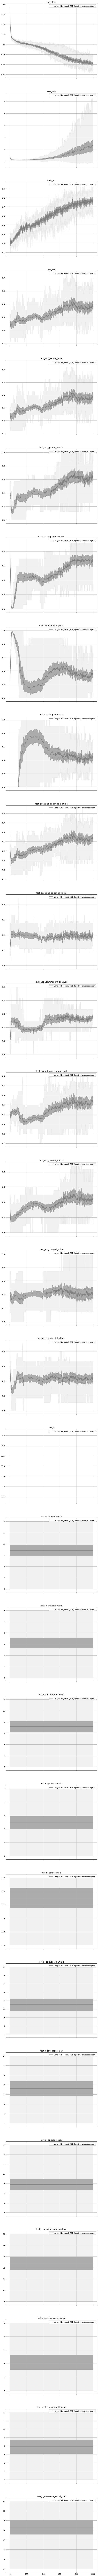

In [10]:
compared_features = ['spectrogram'] #['wav2vec_features-z', 'retrained-wav2vec_features-z']
plot_results(model_names, variables_and_sample_sizes, compared_features)

# Best epoch summaries

In [11]:
def make_label_str(model_name, feature_name):
    m_name = model_name.replace('LangId','')# .replace("1", "")

    f_name = feature_name.replace(
        "retrained-wav2vec_features-z", "OUR  Latent"
    ).replace(
        "retrained-wav2vec_features-c", "OUR  Context"
    ).replace(
        "wav2vec_features-z", "BSLN  Latent"
    ).replace(
        "wav2vec_features-c", "BSLN  Context"
    )


    # return m_name, f_name
    return f"{f_name} - {m_name}"

In [12]:
def plot_summary_results(model_names, variables_and_sample_sizes, compared_features):
    variables = [t[0] for t in variables_and_sample_sizes]
    sample_sizes_by_variable = {t[0]:t[1] for t in variables_and_sample_sizes}
    
    series_means = {v:[] for v in variables}
    series_sems = {v:[] for v in variables}
    series_mins = {v:[] for v in variables}
    series_maxes = {v:[] for v in variables}
    
    series_labels = {v:[] for v in variables}
    
    for variable in variables:
        for feature_prefix in compared_features:
            sample_size = sample_sizes_by_variable[variable]
            for model_name in model_names:
                stats = get_variable_stats(model_name, feature_prefix, variable, sample_size)
                series_means[variable].append(stats['best_epoch_mean'])
                series_sems[variable].append(stats['best_epoch_sem'])
                series_mins[variable].append(stats['best_epoch_min'])
                series_maxes[variable].append(stats['best_epoch_max'])
                series_labels[variable].append((model_name, feature_prefix))
    
    for v in variables:
        df = pd.DataFrame(
            data={
                f'{v}_labels': [make_label_str(l[0], l[1]) for l in series_labels[v]],
                f'{v}_means': series_means[v],
                f'{v}_sems': series_sems[v],
            }
        )
        display(df)
    
    # Variables
    # 'train_loss', 'test_loss', 
    # 'train_acc', 'test_acc', 
    # 'test_acc_gender_male', 'test_acc_gender_female', 
    # 'test_acc_language_maninka', 'test_acc_language_pular', 'test_acc_language_susu'
    
    fig, ax = plt.subplots(figsize=(15, 10))
    #plt.bar(labels, mean_train_acc)
    #print(labels)
    bar_width = 5
    bar_margin = 20
    
    label_count = len(series_labels['test_acc'])
    
    colors = {
        "male": "#58508d",
        "female": "#ff6361",
        "maninka": "#88290d",
        "susu": "#b44f0f",
        "pular": "#dc790b",
        "train": "#7f7f7f",
        "test":"#4682b4"
    }

    
    #('test_acc_speaker_count_multiple', fold_count),
    #('test_acc_speaker_count_single', fold_count),
    
    
    #('test_acc_utterance_multilingual', fold_count),
    #('test_acc_utterance_verbal_nod', fold_count),
    
    
    #('test_acc_channel_music', fold_count),
    #('test_acc_channel_noise', fold_count),
    #('test_acc_channel_telephone', fold_count)
    

    train_y_pos = (bar_width+bar_margin)*np.arange(label_count)
    test_y_pos =(bar_width+bar_margin)*np.arange(label_count)
    test_y_male_pos =(bar_width+bar_margin)*np.arange(label_count) + 3.5
    test_y_female_pos =(bar_width+bar_margin)*np.arange(label_count) + 4.5
    
    test_y_susu_pos =(bar_width+bar_margin)*np.arange(label_count) + 6
    test_y_maninka_pos =(bar_width+bar_margin)*np.arange(label_count) + 7
    test_y_pular_pos =(bar_width+bar_margin)*np.arange(label_count) + 8
    
    test_y_speaker_multi = (bar_width+bar_margin)*np.arange(label_count) + 9.5
    test_y_speaker_single = (bar_width+bar_margin)*np.arange(label_count) + 10.5
    
    test_y_utt_multilingual = (bar_width+bar_margin)*np.arange(label_count) + 12
    test_y_utt_verbal_nod = (bar_width+bar_margin)*np.arange(label_count) + 13
    
    test_y_channel_music = (bar_width+bar_margin)*np.arange(label_count) + 14.5
    test_y_channel_noise = (bar_width+bar_margin)*np.arange(label_count) + 15.5
    test_y_channel_telephone = (bar_width+bar_margin)*np.arange(label_count) + 16.5


    ax.barh(train_y_pos, series_means['train_acc'], height=5, xerr=series_sems['train_acc'], color=colors['train'])
    ax.barh(test_y_pos, series_means['test_acc'], height=5, xerr=series_sems['test_acc'], color=colors['test']) # color=COLORS[2]
    
    bias_alpha = 0.6
    ax.barh(test_y_male_pos, series_means['test_acc_gender_male'], height=1, xerr=series_sems['test_acc_gender_male'], color=colors['male'], alpha=bias_alpha)
    ax.barh(test_y_female_pos, series_means['test_acc_gender_female'], height=1, xerr=series_sems['test_acc_gender_female'], color=colors['female'], alpha=bias_alpha)
    
    ax.barh(test_y_susu_pos, series_means['test_acc_language_susu'], height=1, xerr=series_sems['test_acc_language_susu'], color=colors['susu'], alpha=bias_alpha)
    ax.barh(test_y_maninka_pos, series_means['test_acc_language_maninka'], height=1, xerr=series_sems['test_acc_language_maninka'], color=colors['maninka'], alpha=bias_alpha)
    ax.barh(test_y_pular_pos, series_means['test_acc_language_pular'], height=1, xerr=series_sems['test_acc_language_pular'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_speaker_multi, series_means['test_acc_speaker_count_multiple'], height=1, xerr=series_sems['test_acc_speaker_count_multiple'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_speaker_single, series_means['test_acc_speaker_count_single'], height=1, xerr=series_sems['test_acc_speaker_count_single'], color=colors['pular'], alpha=bias_alpha)
    
    ax.barh(test_y_utt_multilingual, series_means['test_acc_utterance_multilingual'], height=1, xerr=series_sems['test_acc_utterance_multilingual'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_utt_verbal_nod, series_means['test_acc_utterance_verbal_nod'], height=1, xerr=series_sems['test_acc_utterance_verbal_nod'], color=colors['pular'], alpha=bias_alpha)

    ax.barh(test_y_channel_music, series_means['test_acc_channel_music'], height=1, xerr=series_sems['test_acc_channel_music'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_noise, series_means['test_acc_channel_noise'], height=1, xerr=series_sems['test_acc_channel_noise'], color=colors['pular'], alpha=bias_alpha)
    ax.barh(test_y_channel_telephone, series_means['test_acc_channel_telephone'], height=1, xerr=series_sems['test_acc_channel_telephone'], color=colors['pular'], alpha=bias_alpha)

    for i, label in enumerate(series_labels['test_acc']):
        (model_name, feature_name) = label

        
        
        label_str = make_label_str(model_name, feature_name)

        train_acc_label_str = f"{series_means['train_acc'][i]:.02%}"
        test_acc_label_str = f"{series_means['test_acc'][i]:.02%}"

        ax.text(0.01, train_y_pos[i], label_str, color='white', fontsize="x-large", fontweight="bold")

        ax.text(series_means['train_acc'][i]-0.07, train_y_pos[i]-0.7, train_acc_label_str, color='white', fontsize="large")
        ax.text(series_means['test_acc'][i]-0.07, train_y_pos[i]-0.7, test_acc_label_str, color='white', fontsize="large")
        

        
        ax.text(0.01, test_y_male_pos[i]-0.3, f"male ({series_means['test_n_gender_male'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_female_pos[i]-0.3, f"female ({series_means['test_n_gender_female'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_susu_pos[i]-0.3, f"susu ({series_means['test_n_language_susu'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_maninka_pos[i]-0.3, f"maninka ({series_means['test_n_language_maninka'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_pular_pos[i]-0.3, f"pular ({series_means['test_n_language_pular'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_speaker_multi[i]-0.3, f"multi speakers ({series_means['test_n_speaker_count_multiple'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_speaker_single[i]-0.3, f"single speaker ({series_means['test_n_speaker_count_single'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_utt_multilingual[i]-0.3, f"multi-lingual utt ({series_means['test_n_utterance_multilingual'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_utt_verbal_nod[i]-0.3, f"verbal nod utt ({series_means['test_n_utterance_verbal_nod'][i]})", color='black', fontsize="small")
        
        ax.text(0.01, test_y_channel_music[i]-0.3, f"music ({series_means['test_n_channel_music'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_noise[i]-0.3, f"noise ({series_means['test_n_channel_noise'][i]})", color='black', fontsize="small")
        ax.text(0.01, test_y_channel_telephone[i]-0.3, f"telephone ({series_means['test_n_channel_telephone'][i]})", color='black', fontsize="small")
        
        
        ax.legend(["TRAIN", "TEST", "TEST (Male)", "TEST (Female)", "TEST (Susu)", "TEST (Maninka)", "TEST (Pular)"])
        ax.set_xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.set_title(f"Average and SEM (n=10 folds) Language Identification Accuracies. Conv Dropout p={dropout_rate}. FC Dropout p={fc_dropout_rate}")
        ax.grid(True)

        
        


,train_loss_labels,train_loss_means,train_loss_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.828818,0.067449


,test_loss_labels,test_loss_means,test_loss_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,1.177403,0.085869


,train_acc_labels,train_acc_means,train_acc_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.566667,0.060655


,test_acc_labels,test_acc_means,test_acc_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.6,0.028036


,test_acc_gender_male_labels,test_acc_gender_male_means,test_acc_gender_male_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.589516,0.030862


,test_acc_gender_female_labels,test_acc_gender_female_means,test_acc_gender_female_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.680357,0.063744


,test_acc_language_maninka_labels,test_acc_language_maninka_means,test_acc_language_maninka_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.607933,0.060363


,test_acc_language_pular_labels,test_acc_language_pular_means,test_acc_language_pular_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.729304,0.060272


,test_acc_language_susu_labels,test_acc_language_susu_means,test_acc_language_susu_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.405512,0.097636


,test_acc_speaker_count_multiple_labels,test_acc_speaker_count_multiple_means,test_acc_speaker_count_multiple_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.617238,0.043413


,test_acc_speaker_count_single_labels,test_acc_speaker_count_single_means,test_acc_speaker_count_single_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.546513,0.030753


,test_acc_utterance_multilingual_labels,test_acc_utterance_multilingual_means,test_acc_utterance_multilingual_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.642778,0.058351


,test_acc_utterance_verbal_nod_labels,test_acc_utterance_verbal_nod_means,test_acc_utterance_verbal_nod_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.653367,0.02865


,test_acc_channel_music_labels,test_acc_channel_music_means,test_acc_channel_music_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.480227,0.072131


,test_acc_channel_noise_labels,test_acc_channel_noise_means,test_acc_channel_noise_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.663571,0.041431


,test_acc_channel_telephone_labels,test_acc_channel_telephone_means,test_acc_channel_telephone_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,0.646919,0.030038


,test_n_labels,test_n_means,test_n_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,33.0,0.0


,test_n_channel_music_labels,test_n_channel_music_means,test_n_channel_music_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,9.4,0.493964


,test_n_channel_noise_labels,test_n_channel_noise_means,test_n_channel_noise_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,7.1,0.457165


,test_n_channel_telephone_labels,test_n_channel_telephone_means,test_n_channel_telephone_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,9.6,0.493964


,test_n_gender_female_labels,test_n_gender_female_means,test_n_gender_female_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,6.5,0.474342


,test_n_gender_male_labels,test_n_gender_male_means,test_n_gender_male_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,31.7,0.144914


,test_n_language_maninka_labels,test_n_language_maninka_means,test_n_language_maninka_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,11.5,0.681909


,test_n_language_pular_labels,test_n_language_pular_means,test_n_language_pular_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,11.6,0.764199


,test_n_language_susu_labels,test_n_language_susu_means,test_n_language_susu_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,9.9,0.555878


,test_n_speaker_count_multiple_labels,test_n_speaker_count_multiple_means,test_n_speaker_count_multiple_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,22.4,0.56921


,test_n_speaker_count_single_labels,test_n_speaker_count_single_means,test_n_speaker_count_single_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,10.1,0.537587


,test_n_utterance_multilingual_labels,test_n_utterance_multilingual_means,test_n_utterance_multilingual_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,7.9,0.817924


,test_n_utterance_verbal_nod_labels,test_n_utterance_verbal_nod_means,test_n_utterance_verbal_nod_sems
0,spectrogram - CNN_Mean2_FCD_Spectrogram,18.3,0.735527


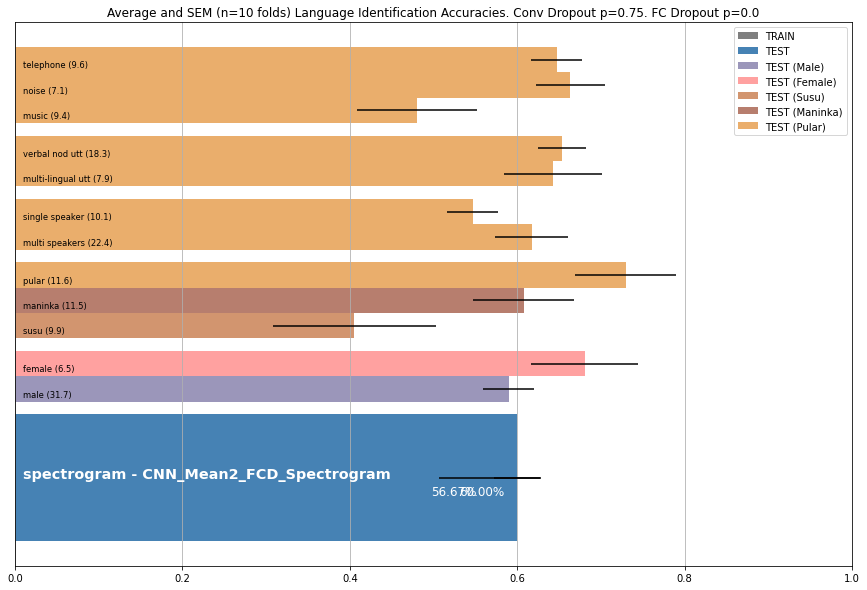

In [13]:
compared_features_latent = ['spectrogram'] #['wav2vec_features-z', 'retrained-wav2vec_features-z']
compared_features_ctx = ['spectrogram'] #['wav2vec_features-c', 'retrained-wav2vec_features-c']

for model_name in model_names:
    plot_summary_results([model_name], variables_and_sample_sizes, compared_features_latent)
    # plot_summary_results([model_name], variables_and_sample_sizes, compared_features_ctx)


# Part 2 Model Attention Analysis

## Utilities from Training notebook

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from pathlib import Path
import h5py
import numpy as np

In [15]:
annotation_specification = {
    0: {
        'id': 0,
        'label': "maninka",
        'required_tags': set(['ct-speech', 'lng-maninka']),
        'forbidden_tags':  set(['lng-susu', 'lng-pular'])
    },
    1: {
        'id': 1,
        'label': "susu",
        'required_tags': set(['ct-speech', 'lng-susu']),
        'forbidden_tags':  set(['lng-maninka', 'lng-pular'])
    },
    2: {
        'id': 2,
        'label': "pular",
        'required_tags': set(['ct-speech', 'lng-pular']),
        'forbidden_tags':  set(['lng-susu', 'lng-maninka'])
    }
}

ANNOTATIONS_PATH = "/media/xtrem/data/experiments/nicolingua-0001-language-id/language-id-annotations/metadata.csv"
AUDIO_SAMPLES_PATH = "/media/xtrem/data/experiments/nicolingua-0001-language-id/language-id-annotations/audio_samples"
FEATURE_DIRS = [
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/wav2vec_features-z',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-c',
    '/media/xtrem/data/experiments/nicolingua-0001-language-id/retrained-wav2vec_features-z'
]

FEATURE_NAMES = ['wav2vec_features-z', 'retrained-wav2vec_features-z']

GPU_ID = 1
device = torch.device(f"cuda:{GPU_ID}")

COLORS = ["#7f7f7f", "#1f77b4"]

In [16]:
def to_user_friendly_feature_name(fv_name):
    name = fv_name \
        .replace("features-", "") \
        .replace("wav2vec_", "") \
        .replace("average", "avg") \
        .replace("timestep", "T") \
        .replace("c.", "Context") \
        .replace("z.", "Latent")
    return name

In [17]:
def load_annotations(a_file_path, a_specification):
    with open(ANNOTATIONS_PATH) as f:
        reader = csv.DictReader(f)
        for row in reader:
            tag_set = set([t.strip() for t in row['tags'].split(";")])
            for label in annotation_specification.keys():
                spec = annotation_specification[label]
                if spec['required_tags'].issubset(tag_set):
                    if spec['forbidden_tags'].isdisjoint(tag_set):
                        yield row['file'], label, tag_set
                        break

data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
audio_files, audio_labels, audio_tags = zip(*data)

In [18]:
def inspect_label_counts():
    for label in annotation_specification:
        count = len([l for l in audio_labels if l == label])
        print("{:10} ({}): {}".format(
            annotation_specification[label]['label'],
            label, 
            count
        ))
inspect_label_counts()

maninka    (0): 114
susu       (1): 32
pular      (2): 28


In [19]:
count_per_class = 28
data = list(load_annotations(ANNOTATIONS_PATH, annotation_specification))
balanced_data = []
for label in annotation_specification:
    balanced_data.extend([d for d in data if d[1] == label][:count_per_class])
audio_files, audio_labels, audio_tags = zip(*balanced_data)

In [20]:
inspect_label_counts()

maninka    (0): 28
susu       (1): 28
pular      (2): 28


In [21]:
def load_features(audio_files, features_input_dir):
    id_list = []
    features_list = []

    for audio_file_name in audio_files:
        feature_file_name = audio_file_name.replace(".wav", ".h5context")
        feature_path = Path(features_input_dir) / feature_file_name
        with h5py.File(feature_path, 'r') as f:
            features_shape = f['info'][1:].astype(int)
            features = np.array(f['features'][:]).reshape(features_shape)
            # features = pool_feature_last_seq(features)
            features_list.append(features)
    return features_list

In [22]:
raw_features = {}
for feature_dir in FEATURE_DIRS:
    feature_name = Path(feature_dir).stem
    raw_features[feature_name] = load_features(audio_files, feature_dir)

In [23]:
for feature_name in raw_features.keys():
    print("feature_name: {}. feature shape: {}".format(
        to_user_friendly_feature_name(feature_name),
        raw_features[feature_name][0].shape
    ))

feature_name: c. feature shape: (2998, 512)
feature_name: z. feature shape: (2998, 512)
feature_name: retrained-c. feature shape: (2998, 512)
feature_name: retrained-z. feature shape: (2998, 512)


In [24]:
class LangIdCNN_Mean2_FCD(nn.Module):
    def __init__(self, dropout_p, fc_dropout_p):
        super(LangIdCNN_Mean2_FCD, self).__init__()
        
        self.conv0 = nn.Conv1d(in_channels=512, out_channels=3, kernel_size=1)
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop3 = nn.Dropout(p=dropout_p)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=3)
        self.drop4 = nn.Dropout(p=dropout_p)
        self.pool4 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.drop5 = nn.Dropout(p=fc_dropout_p)

        self.lin6 = nn.Linear(in_features=9, out_features=3)
        
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        x = self.conv0(x)
        
        x = self.conv1(x)
        x = F.elu(x)
        x = self.drop1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = F.elu(x)
        x = self.drop2(x)
        x = self.pool2(x)
        
        v1 = torch.mean(x, dim=2)
        
        x = self.conv3(x)
        x = F.elu(x)
        x = self.drop3(x)
        x = self.pool3(x)
        
        v2 = torch.mean(x, dim=2)
        
        x = self.conv4(x)
        x = F.elu(x)
        x = self.drop4(x)
        x = self.pool4(x)
        
        v3 = torch.mean(x, dim=2)
        
        v = torch.cat((v1, v2, v3), axis=1)
        v = self.drop5(v)
        
        x = self.lin6(v)
        
        return v, x

## Load best model checkpoints

In [25]:
def load_best_checkpoints(feature_names):
    best_checkpoints = []

    for model_name in model_names:
        for feature_name in feature_names:
            best_epochs = get_best_epochs_per_fold(model_name, feature_name, best_epoch_selection_variable='test_acc')
            #print(f'{model_name} {feature_name} {best_epochs}')
            for fold_id, epoch in enumerate(best_epochs):
                checkpoint_path = f'{DATA_DIR}/{model_name}/{feature_name}_{fold_id}_checkpoints/{epoch:04}.pt'
                checkpoint_data = torch.load(checkpoint_path)
                # print(f'Loaded {checkpoint_path}')

                assert(epoch == checkpoint_data['epoch'])
                assert(fold_id == checkpoint_data['fold_id'])
                assert(feature_name == checkpoint_data['feature_name'])
                assert(model_name == checkpoint_data['model_name'])

                dropout_p = checkpoint_data['dropout_p']
                fc_dropout_p = checkpoint_data['fc_dropout_p']

                model_state_dict = checkpoint_data['model_state_dict']
                # optimizer_state_dict = checkpoint_data['optimizer_state_dict']

                model = LangIdCNN_Mean2_FCD(dropout_p, fc_dropout_p)
                model.load_state_dict(model_state_dict)
                model.eval()

                best_checkpoints.append({
                    "feature_name": feature_name,
                    "fold_id": fold_id,
                    "model": model
                })
    return best_checkpoints
                

best_checkpoints = load_best_checkpoints(FEATURE_NAMES)
            
print(best_checkpoints)

IndexError: list index out of range

# Compute data for attention visualization
- For each checkpoint:
    - representations
    - logits
    - class probabilities
    - KL divergences between predicted probabilities and one-hot ground truth probabilities
    - input graditents w.r.t. each predicted class logit

### One-hot audio labels

In [ ]:
audio_labels_one_hot = np.zeros((len(audio_labels), 3))
for i in range(len(audio_labels)):
    audio_labels_one_hot[i, audio_labels[i]] = 1

### representations, logits, class probs, kl divs, gradients

In [ ]:
for checkpoint in best_checkpoints:
    features = np.array(raw_features[checkpoint['feature_name']])
    x = torch.tensor(features, requires_grad=True).to(device)
    
    model = checkpoint['model'].to(device)
    representations, logits = model(x)
    class_probs = F.softmax(logits, dim=1)
    class_log_softmax = torch.log(class_probs)
    class_kl_divs = F.kl_div(class_log_softmax, torch.tensor(audio_labels_one_hot).to(device), reduction="none").sum(dim=1)
    
    
    checkpoint["representations"] = representations.detach().cpu().numpy()
    checkpoint["class_logits"] = logits.detach().cpu().numpy()
    checkpoint["class_probs"] = class_probs.detach().cpu().numpy()
    checkpoint["kl_divs"] = class_kl_divs.detach().cpu().numpy()
    
    checkpoint["input_gradients_by_class_index"] = {}
    
    for class_index in range(logits.shape[1]):
        class_input_gradients = torch.autograd.grad(logits[:, class_index].sum(), x, retain_graph=True)[0]
        checkpoint["input_gradients_by_class_index"][class_index] = class_input_gradients.detach().cpu().numpy()
        
    input_gradients = torch.autograd.grad(logits[:, :].sum(), x, retain_graph=True)[0]
    checkpoint["input_gradients"] = input_gradients.detach().cpu().numpy()
        
        
        

In [ ]:
def get_kl_div_by_feature(best_checkpoints, feature_name):
    feature_best_checkpoints = [c for c in best_checkpoints if c['feature_name'] == feature_name]
    all_kl_divs = np.array([checkpoint['kl_divs'] for checkpoint in feature_best_checkpoints])
    mean_kl_divs = np.mean(all_kl_divs, axis=0)
    n_folds = all_kl_divs.shape[0]
    sem_kl_divs = np.std(all_kl_divs, axis=0) / np.sqrt(n_folds)
    
    return mean_kl_divs, sem_kl_divs

def get_datum_attention(best_checkpoints, feature_name, example_index):
    feature_best_checkpoints = [c for c in best_checkpoints if c['feature_name'] == feature_name]
    gradients = np.array([checkpoint['input_gradients'][example_index] for checkpoint in feature_best_checkpoints])
    # np.mean(gradients, axis=0)
    # print(gradients.shape)
    
    return gradients
    
    
# ['wav2vec_features-z', 'retrained-wav2vec_features-z']

mean_kl_divs_bsln, sem_kl_divs_bsln = get_kl_div_by_feature(best_checkpoints, "wav2vec_features-z")
mean_kl_divs_ours, sem_kl_divs_ours = get_kl_div_by_feature(best_checkpoints, "retrained-wav2vec_features-z")
    
plt.figure(figsize=(30, 7))
bar_width = 1
bar_margin = 2

x_bsln = np.arange(mean_kl_divs_bsln.shape[0])# * (bar_width + bar_margin)
x_ours = np.arange(mean_kl_divs_ours.shape[0])# * (bar_width + bar_margin) + 5
plt.bar(x_bsln, mean_kl_divs_bsln, alpha=0.7, color=BSLN_COLOR, yerr=sem_kl_divs_bsln)
plt.bar(x_ours, mean_kl_divs_ours, alpha=0.7, color=OUR_COLOR, yerr=sem_kl_divs_ours)
plt.xticks(x_bsln)

plt.legend(['bsln', 'ours'])

In [ ]:
bsln_difficult_example_indices = np.argsort((mean_kl_divs_bsln - mean_kl_divs_ours) / mean_kl_divs_ours)[::-1]
print(bsln_difficult_example_indices)

In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import scipy

def resample_attention(al, temporal_bins):
    buckets = np.array_split(al, temporal_bins)
    resampled = np.array([np.mean(b) for b in buckets])
    return resampled
    
def display_datum(
    datum_index,
    datum_name, 
    bsln_mean_kld, our_mean_kld, 
    bsln_attention_line, bsln_attention_line_sem, bsln_special_attention,
    our_attention_line, our_attention_line_sem, our_special_attention):
    
    display(HTML(f"<h3>{datum_name} (index: {datum_index})</h3>"))
    display(HTML(f"<h4>Baseline KL-Divergence: {bsln_mean_kld:.03}</h4>"))
    display(HTML(f"<h4>Our KL-Divergence: {our_mean_kld:.03}</h4>"))
    display(HTML(f"<h4>Relative BSLN KL-Divergence of baseline w.r.t OURS: {(bsln_mean_kld - our_mean_kld) / our_mean_kld:.03%}</h4>"))
    
    
    
    audio_path = Path(AUDIO_SAMPLES_PATH) / datum_name
    display(ipd.Audio(audio_path))
    
    
    plt.figure(figsize=(30, 5))
    #fig, ax = plt.subplots(2, 1, sharex=True)

    x, sr = librosa.load(audio_path)
    
    
    ax1 = plt.subplot(411)
    display(librosa.display.waveplot(x, sr=sr))
    
    plt.subplot(412, sharex=ax1)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    display(librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz'))
    
    plt.subplot(413, sharex=ax1)
    
    # Note from wav2vec
    # The output of the encoder is a low frequency
    # feature representation zi ∈ Z which encodes about 30 ms of 16 kHz of audio and the striding results
    # in representations zi every 10ms. (10/1000 seconds)
    t_e = np.arange(bsln_attention_line.shape[0]) * (10/1000)
    t_e_ticks = np.arange(30000, step=500) / 1000
    ax1.set_xticks(t_e_ticks)
    ax1.set_xticklabels(t_e_ticks)
        
    plt.plot(t_e, bsln_attention_line, color=BSLN_COLOR)
    plt.fill_between(
        t_e, 
        bsln_attention_line - bsln_attention_line_sem,
        bsln_attention_line + bsln_attention_line_sem,
        alpha=0.3,
        color=BSLN_COLOR
    )
    
    
    plt.plot(t_e, our_attention_line, color=OUR_COLOR)
    plt.fill_between(
        t_e,
        our_attention_line - our_attention_line_sem,
        our_attention_line + our_attention_line_sem,
        alpha=0.3,
        color=OUR_COLOR
    )
    
    plt.legend(['bsln', 'our'])
    
    
    plt.subplot(414, sharex=ax1)
    plt.fill_between(t_e, 0, bsln_special_attention, color=BSLN_COLOR, alpha=0.5)
    plt.fill_between(t_e, 0, our_special_attention, color=OUR_COLOR, alpha=0.5)
    
    
    
        
    plt.show()
    

In [ ]:
def generate_audacity_markers(fname, special_attention_series, marker_prefix):
    print(fname)
    current_state = special_attention_series[0]
    marker_count = 0
    for index, spa in enumerate(special_attention_series):
        if spa != current_state:
            if spa:
                marker_begin_index = index
            else:
                marker_end_index = index
                marker_count += 1
                
                marker_begin_time = marker_begin_index*(10/1000)
                marker_end_time = marker_end_index*(10/1000)
                marker_name = f'{marker_prefix}_{marker_count}'
                
                print(f"{marker_begin_time}\t{marker_end_time}\t{marker_name}")
            current_state = spa

In [ ]:
def compute_attention_line(gradients):
    ## Compute the magnitude of the gradients
    gradient_magnitudes = np.abs(gradients)
    # print(f"gradient_magnitudes.shape: {gradient_magnitudes.shape}") # (10, 2998, 512)
    
    ## Sum the magnitudes across the 512 neurons
    gradient_sums_accross_neurons = np.sum(gradient_magnitudes, axis=2)
    # print(f"gradient_sums_accross_neurons.shape: {gradient_sums_accross_neurons.shape}")# (10, 2998)
    
    ## Softmax the summed magnitudes over the temporal dimension
    normalized_attention_lines = scipy.special.softmax(gradient_sums_accross_neurons, axis=1)
    # print(f"normalized_attention_lines.shape: {normalized_attention_lines.shape}") # (10, 2998)
    
    ## Compute the mean and STEM attentions across folds
    fold_count = normalized_attention_lines.shape[0]
    mean_attention_line = np.mean(normalized_attention_lines, axis=0)
    sem_attention_lines = np.std(normalized_attention_lines, axis=0) / np.sqrt(fold_count)
    # print(f"mean_attention_line.shape: {mean_attention_line.shape}") # (2998,)
    
    ## Identify special attention temporal regions as regions that receive attention 2 STD above the mean
    mean_ponctual_attention = np.mean(mean_attention_line)
    std_ponctual_attention = np.std(mean_attention_line)
    
    special_attention = mean_attention_line > (mean_ponctual_attention + 2*std_ponctual_attention)
    #print(f"special_attention.shape: {special_attention.shape}") # (2998,)
    
    return mean_attention_line, sem_attention_lines, special_attention
    
    
for example_index in bsln_difficult_example_indices[:3]:
    bsln_gradients = get_datum_attention(best_checkpoints, 'wav2vec_features-z', example_index)
    our_gradients = get_datum_attention(best_checkpoints, 'retrained-wav2vec_features-z', example_index)
    
    bsln_attention_line, bsln_attention_sem_line, bsln_special_attention = compute_attention_line(bsln_gradients)
    
    # print(our_gradients.shape[0] * )
    our_attention_line, our_attention_sem_line, our_special_attention = compute_attention_line(our_gradients)
    
    
    
    display_datum(
        datum_index = example_index,
        datum_name = audio_files[example_index], 
        bsln_mean_kld = mean_kl_divs_bsln[example_index], 
        our_mean_kld = mean_kl_divs_ours[example_index], 
        bsln_attention_line = bsln_attention_line, 
        bsln_attention_line_sem = bsln_attention_sem_line, 
        bsln_special_attention = bsln_special_attention,
        our_attention_line = our_attention_line, 
        our_attention_line_sem = our_attention_sem_line,
        our_special_attention = our_special_attention
    )
    
    generate_audacity_markers(
        f"{audio_files[example_index]}_bsln_attention.txt",
        bsln_special_attention,
        'bsln_special'
    )
    
    generate_audacity_markers(
        f"{audio_files[example_index]}_out_attention.txt",
        our_special_attention,
        'our_special'
    )
        

In [ ]:
np.arange?